In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import yfinance as yf
import mathsModels as mm
import lstm_model as lstm

### dfo:
- Date
- Expiration date / time to expiration
- Stike price
- Current price
- Rate free risk
- Volatility
- Option price

In [2]:
file_path = '../data/OptionsTrades_2016-06-01.csv'
market_file_path = '../data/dataV.csv'

dfo = pd.read_csv(file_path)
dfv = pd.read_csv(market_file_path)

dfo.head()

,underlying_symbol,quote_datetime,sequence_number,root,expiration,strike,option_type,exchange_id,trade_size,trade_price,...,best_bid,best_ask,underlying_bid,underlying_ask,number_of_exchanges,{exchange,bid_size,bid,ask_size,ask}[number_of_exchanges]
0,^VIX,2016-06-01 13:57:58.175,78677916,VIX,2016-06-08,12.5,C,5,1,2.40,...,2.15,2.60,14.750,14.750,1,5.0,269.0,2.15,2420.0,2.60
1,^VIX,2016-06-01 09:48:28.925,8614309,VIX,2016-06-08,13.0,C,5,100,2.10,...,2.05,2.40,15.225,15.225,1,5.0,1577.0,2.05,3648.0,2.40
2,^VIX,2016-06-01 11:51:38.000,52474726,VIX,2016-06-08,13.0,C,5,1,2.15,...,1.70,2.15,14.900,14.900,1,5.0,1181.0,1.70,2533.0,2.15
3,^VIX,2016-06-01 12:10:54.600,57469886,VIX,2016-06-08,13.0,C,5,25,1.85,...,1.70,2.00,14.775,14.775,1,5.0,136.0,1.70,2122.0,2.00
4,^VIX,2016-06-01 12:14:27.650,58435251,VIX,2016-06-08,13.0,C,5,25,1.90,...,1.65,2.05,14.800,14.800,1,5.0,783.0,1.65,813.0,2.05


In [3]:
dfv['Date'] = pd.to_datetime(dfv['Date'])
dfo['quote_datetime'] = pd.to_datetime(dfo['quote_datetime'])
dfo['quote_date'] = pd.to_datetime(dfo['quote_datetime'].dt.date)
dfo['expiration'] = pd.to_datetime(dfo['expiration'])

dfo = pd.merge(dfv[['Date', 'Treasury_Yield', 'volatility']], dfo, left_on='Date', right_on='quote_date', how='inner')


In [4]:
dfo['time_to_expiration'] = (dfo['expiration'] - dfo['quote_datetime']).dt.days

dfo['current_price'] = (dfo['best_bid'] + dfo['best_ask']) / 2

dfo['black_scholes'] = dfo.apply(
    lambda row: mm.blackScholes_VM(
        S=row['current_price'],
        K=row['strike'],
        T=row['time_to_expiration'],
        r=row['Treasury_Yield'], # risk free rate
        sigma=row['volatility'],
        option_type=row['option_type']
    ),
    axis=1
)

e:\ESIEA\Illinois Institute of Technology\MATH 594 Research Project\Prototype\code_\mathsModels.py:45: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [5]:
dfo.head()

,Date,Treasury_Yield,volatility,underlying_symbol,quote_datetime,sequence_number,root,expiration,strike,option_type,...,number_of_exchanges,{exchange,bid_size,bid,ask_size,ask}[number_of_exchanges],quote_date,time_to_expiration,current_price,black_scholes
0,2016-06-01,1.85,0.7611,^VIX,2016-06-01 13:57:58.175,78677916,VIX,2016-06-08,12.5,C,...,1,5.0,269.0,2.15,2420.0,2.60,2016-06-01,6,2.375,2.374811
1,2016-06-01,1.85,0.7611,^VIX,2016-06-01 09:48:28.925,8614309,VIX,2016-06-08,13.0,C,...,1,5.0,1577.0,2.05,3648.0,2.40,2016-06-01,6,2.225,2.224804
2,2016-06-01,1.85,0.7611,^VIX,2016-06-01 11:51:38.000,52474726,VIX,2016-06-08,13.0,C,...,1,5.0,1181.0,1.70,2533.0,2.15,2016-06-01,6,1.925,1.924804
3,2016-06-01,1.85,0.7611,^VIX,2016-06-01 12:10:54.600,57469886,VIX,2016-06-08,13.0,C,...,1,5.0,136.0,1.70,2122.0,2.00,2016-06-01,6,1.850,1.849804
4,2016-06-01,1.85,0.7611,^VIX,2016-06-01 12:14:27.650,58435251,VIX,2016-06-08,13.0,C,...,1,5.0,783.0,1.65,813.0,2.05,2016-06-01,6,1.850,1.849804


In [6]:
X = dfo[['time_to_expiration', 'strike', 'current_price', 'volatility', 'Treasury_Yield']]
y = dfo['trade_price']

In [7]:
X = X.values
y = y.values

scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}, Test MAE: {mae}")

predictions = model.predict(X_test)



Epoch 1/50


46/46 [==============================] - 3s 11ms/step - loss: 2.5726 - mae: 1.0474 - val_loss: 1.0222 - val_mae: 0.7022
Epoch 2/50
46/46 [==============================] - 0s 3ms/step - loss: 0.4728 - mae: 0.4554 - val_loss: 0.0961 - val_mae: 0.2318
Epoch 3/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0876 - mae: 0.2053 - val_loss: 0.0564 - val_mae: 0.1672
Epoch 4/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0568 - mae: 0.1496 - val_loss: 0.0345 - val_mae: 0.1187
Epoch 5/50
46/46 [==============================] - 0s 4ms/step - loss: 0.0392 - mae: 0.1054 - val_loss: 0.0226 - val_mae: 0.0822
Epoch 6/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0309 - mae: 0.0759 - val_loss: 0.0173 - val_mae: 0.0623
Epoch 7/50
46/46 [==============================] - 0s 3ms/step - loss: 0.0260 - mae: 0.0544 - val_loss: 0.0146 - val_mae: 0.0426
Epoch 8/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0248 - mae:

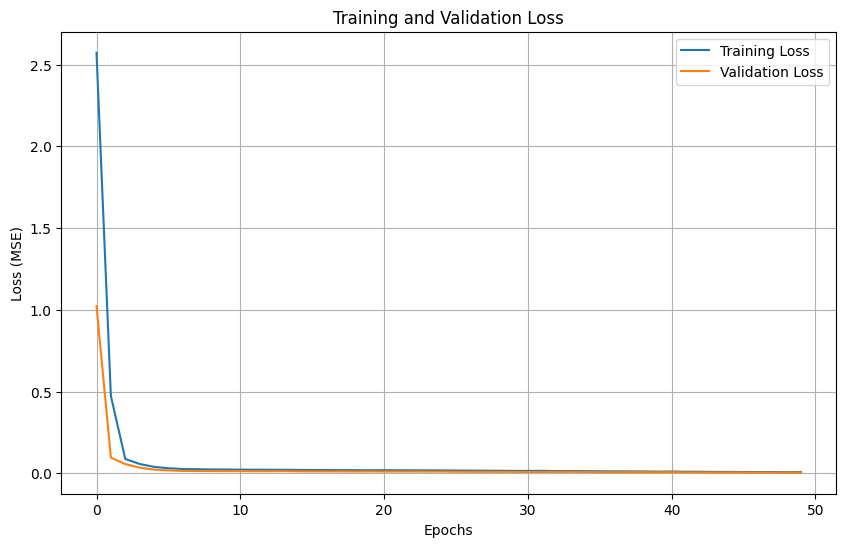

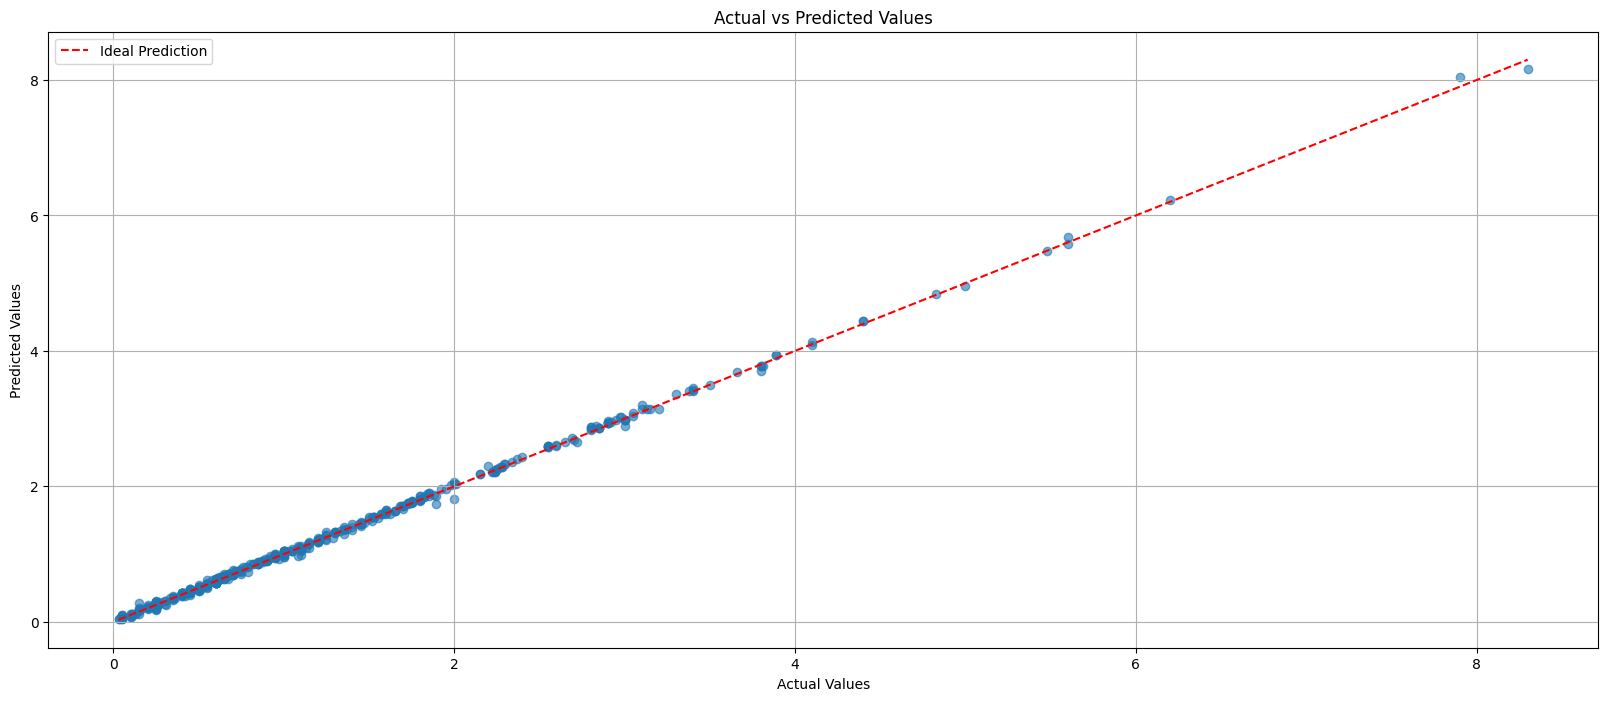

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(20, 8))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid()
plt.show()


15/15 [==============================] - 0s 2ms/step


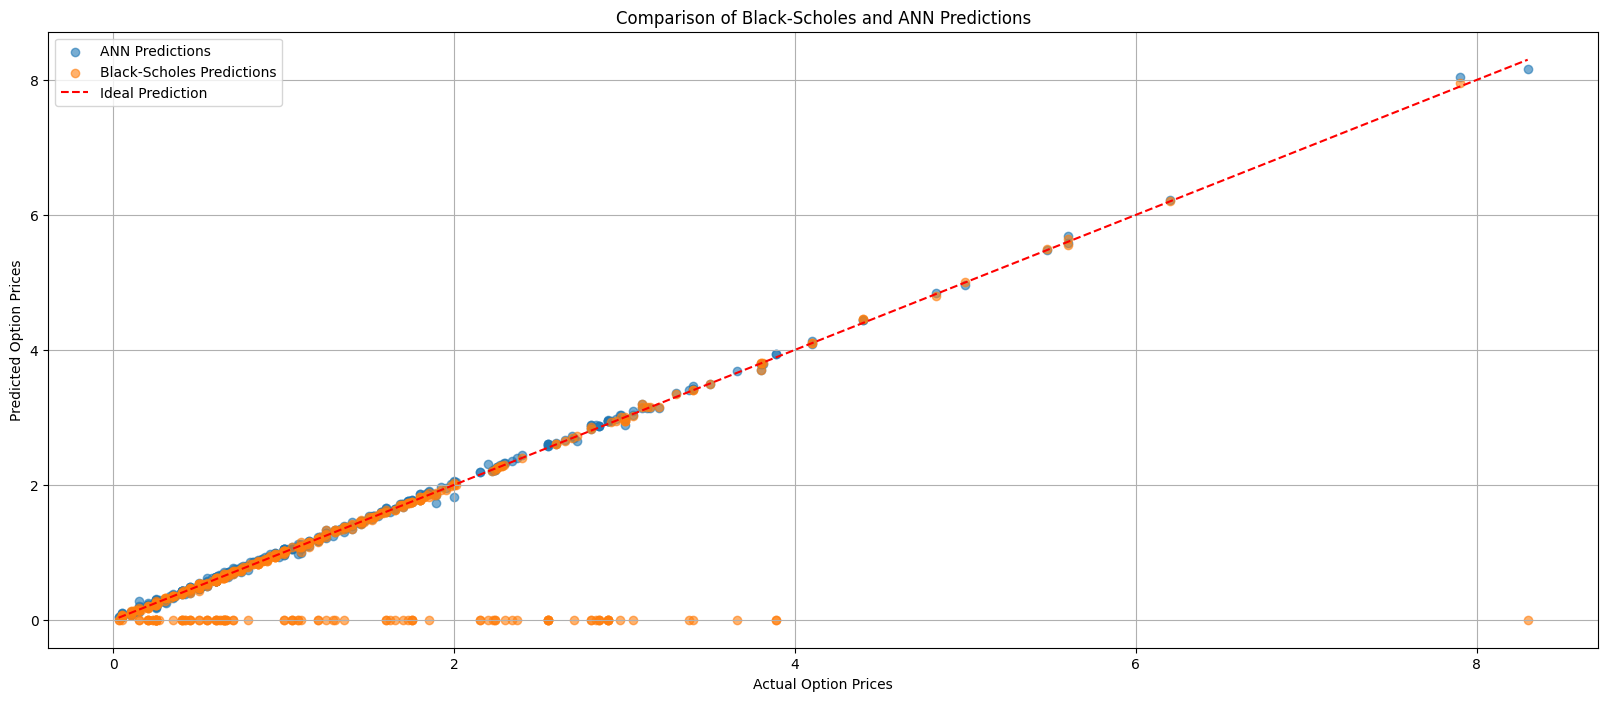

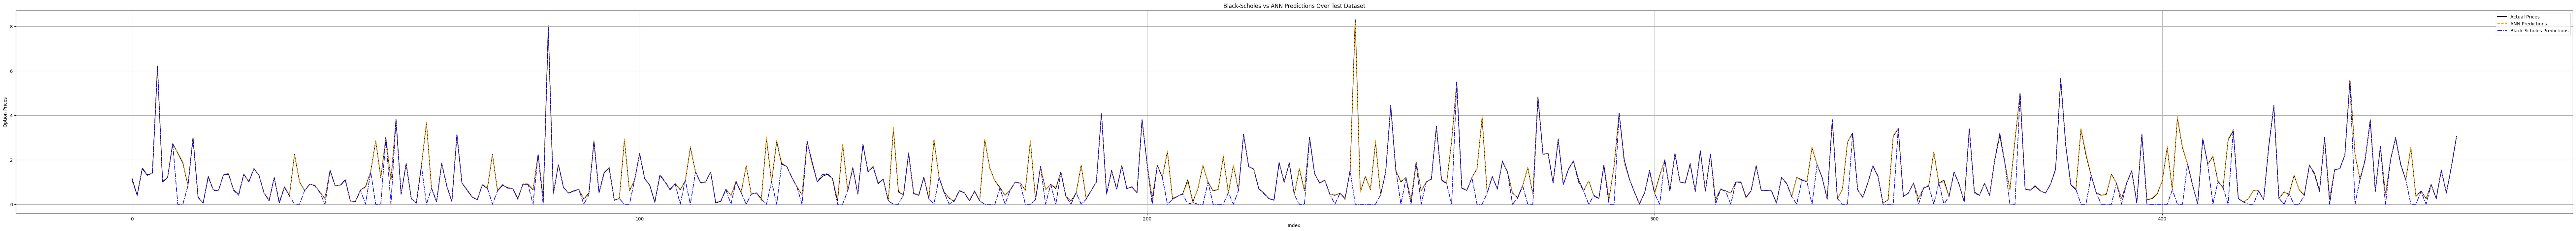

In [10]:
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, dfo.index, test_size=0.2, random_state=42
)

bs_predictions = dfo.loc[test_indices, 'black_scholes'].values

ann_predictions = model.predict(X_test)

plt.figure(figsize=(20, 8))
plt.scatter(y_test, ann_predictions, alpha=0.6, label='ANN Predictions')
plt.scatter(y_test, bs_predictions, alpha=0.6, label='Black-Scholes Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--', label='Ideal Prediction')
plt.xlabel('Actual Option Prices')
plt.ylabel('Predicted Option Prices')
plt.title('Comparison of Black-Scholes and ANN Predictions')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(100, 8))
plt.plot(range(len(y_test)), y_test, label='Actual Prices', linestyle='-', color='black')
plt.plot(range(len(y_test)), ann_predictions, label='ANN Predictions', linestyle='--', color='orange')
plt.plot(range(len(y_test)), bs_predictions, label='Black-Scholes Predictions', linestyle='-.', color='blue')
plt.xlabel('Index')
plt.ylabel('Option Prices')
plt.title('Black-Scholes vs ANN Predictions Over Test Dataset')
plt.legend()
plt.grid()
plt.show()


In [11]:
dfo.to_csv("../data/dataO.csv", index=False)
